In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import pickle
import os
import matlab.engine
from scipy import misc
%pylab inline

In [1]:
import predict_separated_solid as pss

Populating the interactive namespace from numpy and matplotlib


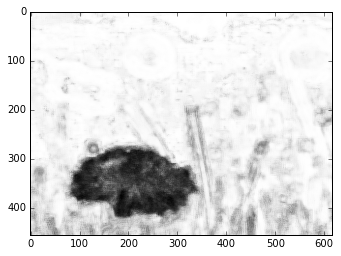

In [2]:
predict = pss.predict('out_of_focus0010')
from matplotlib import pyplot as plt
%pylab inline
plt.imshow(predict,cmap='gray')

In [ ]:
import predict_wsolid as pwo
predict = pwo.predict('out_of_focus0010')
from matplotlib import pyplot as plt
%pylab inline
plt.imshow(predict,cmap='gray')

In [ ]:
import predict_orig as po
predict = po.predict('out_of_focus0010')
from matplotlib import pyplot as plt
%pylab inline
plt.imshow(predict,cmap='gray')

In [ ]:
dirlist = os.listdir('./extracted')[:1000]
feature_list = ['LK','GHS','LPSS','LLF1','LLF2']
label_mark = 'GT'

In [ ]:
def read_im_data(dirname,size):
    size = str(size)
    one_image_data = pd.DataFrame(data=None,columns=feature_list)
    for feature_name in feature_list:
        feature_data = pd.read_csv('./extracted/'+dirname+'/'+size+'/'+feature_name+'.csv',header=-1)
        feature_size = feature_data.values.shape[0]*feature_data.values.shape[1]
        one_image_data[feature_name] = list(map(lambda x: float(x[0]),feature_data.values.transpose().reshape(feature_size,1)))
    one_image_labels = pd.read_csv('./extracted/'+dirname+'/'+size+'/'+label_mark+'.csv',header=-1)
    im_size = list(one_image_labels.shape)
    im_size[0] = im_size[0] + int(size) - 1
    im_size[1] = im_size[1] + int(size) - 1
    one_image_labels = list(map(lambda x: int(x[0]),one_image_labels.values.reshape(feature_size,1)))
    one_image_labels = pd.DataFrame(data=one_image_labels,columns=[label_mark])
    return one_image_data,one_image_labels,im_size

In [ ]:
def convert_data(one_image_data):
    converted_data = []
    for feature_name in feature_list:
        converted_data += [list(map(float,one_image_data[feature_name].values))]
    return converted_data

In [ ]:
def build_index(im_size,patch_size):
    index = []
    im_size = (im_size[0]-patch_size+1,im_size[1]-patch_size+1)
    for i in range(0,im_size[1],patch_size):
        index = index + list(range(i*im_size[0],i*im_size[0]+im_size[0],patch_size))
    return index

In [ ]:
eng = matlab.engine.start_matlab()
eng.addpath(r'C:\Projects\BlurProject\BlurClassification\matlab_scripst_for_validation',nargout=0)

In [ ]:
X,y,im_size = read_im_data('out_of_focus0010',11)
data11 = convert_data(X)

X,y,im_size = read_im_data('out_of_focus0010',15)
data15 = convert_data(X)

X,y,im_size = read_im_data('out_of_focus0010',21)
data21 = convert_data(X)
    
predict = eng.test(im_size,data11,data15,data21)
plt.imshow(predict,cmap='gray')

In [ ]:
y_gt = np.array([])
y_pred = np.array([])
patch_size = 5
for dir_name in dirlist:
    X,y,im_size = read_im_data(dir_name,11)
    data11 = convert_data(X)

    X,y,im_size = read_im_data(dir_name,15)
    data15 = convert_data(X)

    X,y,im_size = read_im_data(dir_name,21)
    data21 = convert_data(X)
    
    predict = eng.test(im_size,data11,data15,data21)
    predict = np.array(predict._data).reshape(predict.size[::-1]).T
    
    gt = misc.imread('./gt/'+dir_name+'.png')
    if len(gt.shape) >2:
        gt = gt[:,:,0]
        
    im_size = gt.shape
    predict = np.array(list(map(lambda x: x[0],predict.reshape(predict.shape[0]*predict.shape[1],1))))
    gt = np.array(list(map(lambda x: int(x[0]/255),gt.reshape(gt.shape[0]*gt.shape[1],1))))
    
   
    
#     index = build_index(im_size,patch_size)
#     predict = predict[index]
#     gt = gt[index]
    
#     y_pred = np.concatenate((y_pred,predict[range(0,predict.shape[0],2)]))
#     y_gt = np.concatenate((y_gt,gt[range(0,gt.shape[0],2)]))
    print(dir_name,y_pred.shape[0])
    print(accuracy_score(gt,predict > 0.5),f1_score(gt,predict > 0.5),roc_auc_score(gt,predict))
    

In [ ]:
eng.quit()

In [ ]:
accuracy_score(y_gt,y_pred > 0.5)

In [ ]:
f1_score(y_gt,y_pred> 0.5)

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
p,r,t = precision_recall_curve(y_gt,y_pred,pos_label = 1)

In [ ]:
fig = plt.figure()
fig.suptitle('Precision-Recall curve', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.plot(r,p)